# Introduction to mixed prediction training using NVIDIA apex

This notebook serves as a small tutorial to introduce PyTorch users to some features of NVIDIA's apex (A Pytorch extension) mixed precision training.
It is heavily based on the GTC talks of [Michael Carilli](https://github.com/mcarilli) and [Christian Sarofeen](https://github.com/csarofeen).

Follow the instructions in the [repo](https://github.com/NVIDIA/apex) to install apex.

author: [Piotr Bialecki](https:github.com/ptrblck)

## Mixed precision training

`apex` provides some tools and utilities for mixed precision training.
In this introduction we'll have a look at mixed precision training in general and the `FP16_Optimizer` specifically.

Before diving into these tools, let's first have a look why we would want to use mixed precision training at all and what benefits we would expect using it.

Based on the talk of Michael Carilli at the GTC Taiwan 2018, there are a some interesing benefits:
 1. 2-4x faster
 2. half the memory use
 3. just as poweful

 with no architecture change.

You can find the talk [here](http://on-demand.gputechconf.com/gtc-taiwan/2018/video/STW8021.mp4).

Let's just setup the small example from the GTC talk and have a look what works just out of the box.

First, let's make sure the model is running fine in FP32.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(2809)
print('PyTorch version {}'.format(torch.__version__))

if not torch.cuda.is_available():
    print('CUDA is necessary for this notebook!')
device = 'cuda'  # change to another GPU id if necessary

PyTorch version 1.0.0.dev20181130


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy

### Simple FP32 training

In [3]:
# Create model in FP32, setup loss function and optimizer
N, D_in, D_out = 64, 1024, 512  # Mutliples of 8 to use TensorCores, in case you have a Volta GPU

x = torch.randn(N, D_in, device=device, dtype=torch.float)
y = torch.randn(N, D_out, device=device, dtype=torch.float)

model = nn.Linear(D_in, D_out).to(device)
state_dict = copy.deepcopy(model.state_dict())  # Save the state_dict so that we can restore it later

optimizer = optim.SGD(model.parameters(), lr=1e-3)  # Set the learning rate a bit higher than in the slides

In [4]:
# Train it for some iterations
fp32_losses = []
for t in range(5000):
    optimizer.zero_grad()
    
    output = model(x)
    loss = F.mse_loss(output, y)
    loss.backward()
    optimizer.step()

    fp32_losses.append(loss.item())

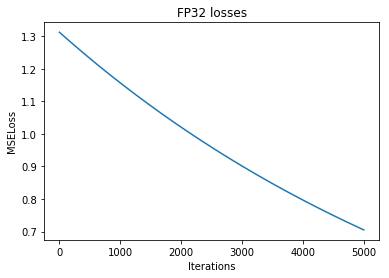

In [5]:
plt.figure()
plt.plot(np.array(fp32_losses))
plt.xlabel('Iterations')
plt.ylabel('MSELoss')
plt.title('FP32 losses')
plt.show()

### Vanilla FP16 training
Alright, that was quite easy and nothing new so far. The loss seems to be decreasing and everything looks alright.

Let's use FP16 now by calling `.half()` on the data, target as well as the model and run the training again.
Additionally we will restore the `state_dict` from our first model just to make sure we are not observing any strange initialization issues in all following tests.

In [6]:
x = x.half()
y = y.half()
model = nn.Linear(D_in, D_out).to(device)
model.load_state_dict(state_dict)  # Restore previsous weights to get rid of random init issues
model = model.half()
fp16_state_dict = copy.deepcopy(model.state_dict())

# Don't forget to recreate the optimizer for your new model!
optimizer = optim.SGD(model.parameters(), lr=1e-3)

Let's make sure the optimizer really stores the `torch.half` parameters and nothing goes wrong.

In [7]:
print(optimizer.param_groups[0]['params'][0])  # Print only first parameter

Parameter containing:
tensor([[-0.0044, -0.0245, -0.0007,  ..., -0.0235, -0.0103, -0.0002],
        [ 0.0071,  0.0273,  0.0174,  ...,  0.0029,  0.0282,  0.0049],
        [-0.0010,  0.0220,  0.0121,  ...,  0.0173, -0.0234,  0.0180],
        ...,
        [ 0.0217, -0.0071,  0.0248,  ...,  0.0034, -0.0288,  0.0303],
        [-0.0220,  0.0242, -0.0042,  ..., -0.0016,  0.0255,  0.0105],
        [ 0.0101, -0.0119, -0.0027,  ..., -0.0035, -0.0187, -0.0214]],
       device='cuda:0', dtype=torch.float16, requires_grad=True)


All set, so let's train the model again.

In [8]:
fp16_losses = []
for t in range(5000):
    optimizer.zero_grad()
    
    output = model(x)
    loss = F.mse_loss(output, y)
    loss.backward()
    optimizer.step()

    fp16_losses.append(loss.item())

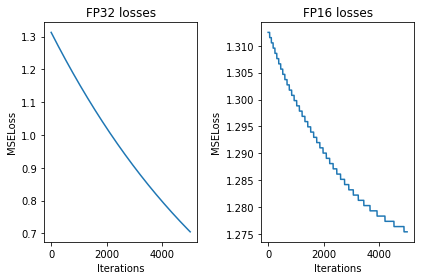

In [9]:
fig, axarr = plt.subplots(1, 2)
axarr[0].plot(np.array(fp32_losses))
axarr[0].set_xlabel('Iterations')
axarr[0].set_ylabel('MSELoss')
axarr[0].set_title('FP32 losses')
axarr[1].plot(np.array(fp16_losses))
axarr[1].set_xlabel('Iterations')
axarr[1].set_ylabel('MSELoss')
axarr[1].set_title('FP16 losses')
fig.tight_layout()

That doesn't seem to be right for the FP16 training.

The loss is not decreasing as in the FP32 case. Also note the steps in the loss curve!
Something might have gone wrong using FP16, so let's think about possible reasons for this strange behavior.

One possible reason for these kind of issues might be **imprecise weight updates** as descriped in the talk. This might be an issue if we are adding small gradients to larger weights. Let's see the example first.

In [10]:
param = torch.tensor([1.0], device=device, dtype=torch.float)
print(param + 0.0001)
param = torch.tensor([1.0], device=device, dtype=torch.half)
print(param + 0.0001)

tensor([1.0001], device='cuda:0')
tensor([1.], device='cuda:0', dtype=torch.float16)


The result of FP16 addition seems to be broken. Maybe `0.0001` is not representable in FP16? Let's have a look.

In [11]:
print(torch.tensor([0.0001], device=device, dtype=torch.half))

tensor([0.0001], device='cuda:0', dtype=torch.float16)


Even though `1.0` as well as `0.0001` are representable using FP16, the addition loses entirely the weight update.

Fortunately we've saved the `state_dict` of your FP16 model, so that we can restore it and run some tests.

### FP32 Master Weights
The recipe given by Michael uses FP32 Master Weights to apply the gradient update. Here is the slide from the talk.

![master_weights](./images/master_weights.png)

Steps 1. and 2. are not changed in this approach. We are still dealing with our FP16 model and run a forward pass using our FP16 data. The backward call calculates also gradients for each parameter using FP16.

However, before the optimizer gets called to perform the weight updates, we copy all FP16 gradients to our FP32 Master Gradients, and apply the weight update on our FP32 Master Weights. 

Thereafter we just copy back the FP32 Master Weights to our model's FP16 weights and can perform another forward pass.
This approach makes sure our model stays in FP16 (with all possible performance benefits), while the sensitive gradient update step is performed in FP32.

There is still one thing missing. How can the optimizer update our FP32 Master Weights without any knowledge about these parameters? The vanilla approach is to pass the `model.parameters()` to the optimizer, so that it can update these.

Well, there is one trick we are using here, so let's have a look at some code and useful helper functions.

`apex.fp16_utils.prep_param_list` is a helper function to create FP32 master parameters for any model.
Here is a small extract of the source code (I've removed some optimized code, as it's not needed to understand the method).

```python
def prep_param_lists(model, flat_master=False):
    model_params = [param for param in model.parameters() if param.requires_grad]

    if flat_master:
        # ignore for now
    else:
        master_params = [param.clone().float().detach() for param in model_params]
        for param in master_params:
            param.requires_grad = True
        return model_params, master_params
```

First, we extract all model parameters which require gradients for easy copying the master parameters back to the model.
Using these parameters we create a copy of each parameter in FP32 and make sure to detach them from the computation graph. This makes sure that Autograd won't try to apply any gradient calculations on our master parameters when we call `backward` on the loss.

To copy the FP16 gradients to FP32 Master Gradients (step 3 in the recipe) we use another helper function named `model_grads_to_master_grads`. Let's have a look at this function, too:

```python
def model_grads_to_master_grads(model_params, master_params, flat_master=False):
    if flat_master:
        ...
    else:
        for model, master in zip(model_params, master_params):
            if model.grad is not None:
                if master.grad is None:
                    master.grad = Variable(master.data.new(*master.data.size()))
                master.grad.data.copy_(model.grad.data)
            else:
                master.grad = None
```
Basically the function does exactly as its name suggests, it's copying the model gradients into the master gradients and creates the master gradients first if necessary.

The copying of the FP32 Master Weights back to our model is performed using `master_params_to_model_params`.

Let's try to implement this approach using all mentioned helper functions.

In [12]:
from apex.fp16_utils import prep_param_lists, master_params_to_model_params, model_grads_to_master_grads

model.load_state_dict(fp16_state_dict)
model_params, master_params = prep_param_lists(model)

optimizer = optim.SGD(master_params, lr=1e-3)  # Pass master_params to optimizer!
print('Optimizer param[0]\n', optimizer.param_groups[0]['params'][0])  # Print only first parameter (Is now FP32)
print('Model weight\n', model.weight.data)

Optimizer param[0]
 tensor([[-0.0044, -0.0245, -0.0007,  ..., -0.0235, -0.0103, -0.0002],
        [ 0.0071,  0.0273,  0.0174,  ...,  0.0029,  0.0282,  0.0049],
        [-0.0010,  0.0220,  0.0121,  ...,  0.0173, -0.0234,  0.0180],
        ...,
        [ 0.0217, -0.0071,  0.0248,  ...,  0.0034, -0.0288,  0.0303],
        [-0.0220,  0.0242, -0.0042,  ..., -0.0016,  0.0255,  0.0105],
        [ 0.0101, -0.0119, -0.0027,  ..., -0.0035, -0.0187, -0.0214]],
       device='cuda:0', requires_grad=True)
Model weight
 tensor([[-0.0044, -0.0245, -0.0007,  ..., -0.0235, -0.0103, -0.0002],
        [ 0.0071,  0.0273,  0.0174,  ...,  0.0029,  0.0282,  0.0049],
        [-0.0010,  0.0220,  0.0121,  ...,  0.0173, -0.0234,  0.0180],
        ...,
        [ 0.0217, -0.0071,  0.0248,  ...,  0.0034, -0.0288,  0.0303],
        [-0.0220,  0.0242, -0.0042,  ..., -0.0016,  0.0255,  0.0105],
        [ 0.0101, -0.0119, -0.0027,  ..., -0.0035, -0.0187, -0.0214]],
       device='cuda:0', dtype=torch.float16)


As you can see, the optimizer indeed stores the FP32 copies of our original FP16 model parameters. Now let's implement all recipe shown in Michaels slide. Each step is described as a small comment in the code.

In [13]:
fp16_master_losses = []
for t in range(5000):
    # Clear the model FP16 gradients, not the ones in optimizer,
    # since it's holding now the reference to the FP32 Master Weights!
    model.zero_grad()
    
    # Step 1: Forward pass in FP16
    output = model(x)
    loss = F.mse_loss(output, y)
    
    # Step 2: Compute backwards on FP16 model params
    loss.backward()
    
    # Step3: Copy model FP16 gradients to master params
    model_grads_to_master_grads(model_params, master_params)
    
    # Step 4: Update master params
    optimizer.step()
    
    # Step 5: Copy master params back to model params
    master_params_to_model_params(model_params, master_params)

    fp16_master_losses.append(loss.item())

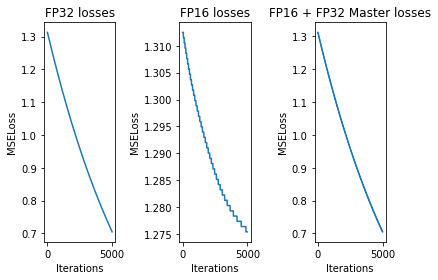

In [14]:
fig, axarr = plt.subplots(1, 3)
axarr[0].plot(np.array(fp32_losses))
axarr[0].set_xlabel('Iterations')
axarr[0].set_ylabel('MSELoss')
axarr[0].set_title('FP32 losses')
axarr[1].plot(np.array(fp16_losses))
axarr[1].set_xlabel('Iterations')
axarr[1].set_ylabel('MSELoss')
axarr[1].set_title('FP16 losses')
axarr[2].plot(np.array(fp16_master_losses))
axarr[2].set_xlabel('Iterations')
axarr[2].set_ylabel('MSELoss')
axarr[2].set_title('FP16 + FP32 Master losses')
axarr[2].set_xlabel('Iterations')
fig.tight_layout()

Here we go! Now the FP16 loss curve using FP32 master params looks pretty much like the original FP32 one.

But wait a moment... Let's recap what we've done so far. We are using an FP16 model with all the potential benefits the apex team has mentioned, however we are storing copies of the weights and are also copying the gradients to our FP32 master gradients.

In fact we are using more memory now than if we would just stick to using FP32 from the beginning. The model might be faster through, so are we just trading memory for compute?

Well, actually no. Remember that in a lot of model architectures (especially CNNs) the memory footprint of the intermediate actications is much larger than the actual parameters!

Also, remember what Christian and Michael said in their talks. Your model might already be working just fine calling `.half()` on it without using any recipe! If you haven't seen the talks by now, you should definitely have a look at them.

Let's continue with other potential pitfalls we might encounter using FP16 or mixed precision training.

### Loss (Gradient) Scaling

The other challenge using FP16 is that the gradients might simply underflow, since the dynamic range of FP16 is much smaller that that of FP32. Our `loss.backward()` call would simply create gradients which are that small in magnitude that they are not representable anymore in FP16.

Fortunately, the apex team came up with another trick named **Loss Scaling**!

The basic idea is to try to use the dynamic range of FP16 better by scaling up the loss using some kind of factor **S**.
This factor might be a constant (usually in the power of 2) or might be determined dynamically.

Let's first recap the concept from the GTC talk:

**Loss Scaling**
  1. Multiply the loss by some constant S.
  2. Call `backward()` on scaled loss.
     By chain rule, gradients will also be scaled by S.
     This preserves small gradient values.
  3. Unscale gradients before update `step()`.

Note that selecting a scale factor will **not** affect your learning rate or any other hyperparameter. So you don't have to worry about it.
  
This seems pretty straightforward to implement in code. We'll be using again our FP32 Master Weight code to add loss scaling.

In [15]:
model.load_state_dict(fp16_state_dict)
model_params, master_params = prep_param_lists(model)

optimizer = optim.SGD(master_params, lr=1e-3)
scale_factor = 128.0

fp16_scaled_losses = []
for t in range(5000):
    model.zero_grad()
    
    output = model(x)
    loss = F.mse_loss(output, y)
    scaled_loss = scale_factor * loss.float()  # Scale up the loss
    scaled_loss.backward()  # Call backward on scaled_loss!
    model_grads_to_master_grads(model_params, master_params)
    
    # "Descale" the FP32 master gradients
    for param in master_params:
        param.grad.data.mul_(1./scale_factor)
    optimizer.step()
    master_params_to_model_params(model_params, master_params)

    fp16_scaled_losses.append(loss.item())

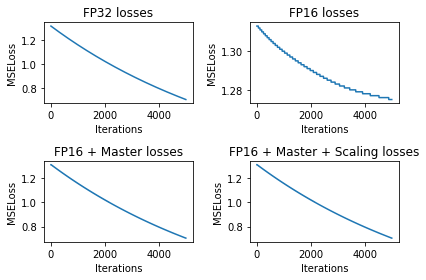

In [16]:
fig, axarr = plt.subplots(2, 2)
axarr = axarr.flatten()
axarr[0].plot(np.array(fp32_losses))
axarr[0].set_xlabel('Iterations')
axarr[0].set_ylabel('MSELoss')
axarr[0].set_title('FP32 losses')
axarr[1].plot(np.array(fp16_losses))
axarr[1].set_xlabel('Iterations')
axarr[1].set_ylabel('MSELoss')
axarr[1].set_title('FP16 losses')
axarr[2].plot(np.array(fp16_master_losses))
axarr[2].set_xlabel('Iterations')
axarr[2].set_ylabel('MSELoss')
axarr[2].set_title('FP16 + Master losses')
axarr[3].plot(np.array(fp16_scaled_losses))
axarr[3].set_xlabel('Iterations')
axarr[3].set_ylabel('MSELoss')
axarr[3].set_title('FP16 + Master + Scaling losses')
fig.tight_layout()

You've might noticed that we are transforming our `loss` to FP32 calling `loss.float()` before scaling it up.
This is just a small additional safety measure, since transforming a single scalar value won't influence the performance in any way. Also don't worry about our FP16 parameters or gradients being also converted to FP32. PyTorch's Autograd will capture this transform operation and makes sure to rewind this operation in the backward call.

Here is our new recipe taken from the GTC slides:

![loss_scaling_recipe](./images/loss_scaling.png)

Whew, this workflow looks a bit complicated now, right? Also, we are currently using a small dummy model and the code gets bigger and bigger. How would the code look like for a "real" model?

Well, don't worry about it! The apex team also provides some beautiful utilitity functions to make our life easier, but let's introduce those methods a bit later.

### Dynamic Loss Scaling

It's often not clear which values to choose for the scaling factor. Even though a scaling factor of `128` seems to work quite good in a lot of use cases, you might want to use Dynamic Loss Scaling, to determing the factor.

Let's recap that loss scaling is used to prevent gradient **underflow** by scaling up the loss. Dynamic Loss Scaling prevents exactly this by using the highest loss scale that does not cause gradient **overflow**.

Here is the recipe for this utility based on the GTC talk:

  1. Start with a large loss scale (e.g. `2**32`)
  2. After each iteration, check if gradients overflowed (`Nan` or +/- `Inf`)
  3. If gradients overflowed, discard the iteration by skipping `optimizer.step()`
  4. If gradients overflowed, reduce [scaling factor] `S` for the next iteration (e.g. `S = S/2`)
  5. If `N` (e.g. 1000) iterations pass with no overflow, increase `S` again (`S = S*2`)
 
This workflow tries to use the highest loss scale that won't cause a gradient overflow and adapts the scale factor dynamically.

### Accumulate in FP32

Sometimes reductions like `sum()` or `mean()` might overflow due to the limitations of FP16. To counter this effect, we should make sure to perform all sensitive reductions in FP32.

Let's use the example from Michael's GTC talk to see, what can go wrong.

In [17]:
a = torch.empty(4094, device=device, dtype=torch.half).fill_(16.0)
print(a.sum())
b = torch.empty(4095, device=device, dtype=torch.half).fill_(16.0)
print(b.sum())

tensor(65504., device='cuda:0', dtype=torch.float16)
tensor(inf, device='cuda:0', dtype=torch.float16)


As you can see we got an `Inf` in the second example, since we encoutered a value bigger than `65,504`. I believe we've all been there seeing our model outputting `Infs` or `NaNs` without any idea how to debug this issue and what could have gone wrong at all.

Using our previous example, we might get into trouble using our current criterion:
```python
loss = F.mse_loss(output, y)  # Both are FP16, thus might overflow!
```

Fortunately again, there is an easy fix for this!
We would just need to cast both values into FP32 so that the reduction won't overflow that easily.
```python
loss = F.mse_loss(output.float(), y.float())  # Won't overflow that easily!
```

Basically, we should be really careful using any reductions in FP16. An example of a typical layer using reductions is `nn.BatchNorm`.

To automatically convert all `nn.BatchNorm` layers in a model, apex provides this utility function, which recursively calls all child modules of our model and converts each BatchNorm to FP32.

```python
def BN_convert_float(module):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.float()
    for child in module.children():
        BN_convert_float(child)
    return module
```

A small side note: You don't have to convert the input to `float` before the `nn.BatchNorm` layer and the output back to `half`, if you are using the cudnn backend, as cudnn takes mixed precision inputs.

### FP16_Optimizer

As mentioned before, let's now have a look at the `FP16_Optimizer` and see, how the usage of this wrapper might simplify mixed precision training for us.

The `FP16_Optimizer` is an optimizer wrapper that automatically manages loss scaling and the FP32 Master Weights for us. It has some more features like an optionally automatic management of dynamic loss scaling, it's closure-safe (interesting for LBFGS), and compatible with PyTorch distributed training.

Let's rewrite our small example using this utility and compare both approaches.

Recall our manual approach:
```python
model_params, master_params = prep_param_lists(model)

optimizer = optim.SGD(master_params, lr=1e-3)
scale_factor = 128.0

for t in range(5000):
    model.zero_grad()  # Clear the model FP16 gradients, not the ones in optimizer!
    
    output = model(x)  # Forward pass in FP16
    loss = F.mse_loss(output, y)
    scaled_loss = scale_factor * loss.float()  # Scale up the loss
    scaled_loss.backward()  # Call backward on scaled_loss!
    model_grads_to_master_grads(model_params, master_params)  # Copy model FP16 gradients to master params
    
    # "Descale" the FP32 master gradients
    for param in master_params:
        param.grad.data.mul_(1./scale_factor)
    optimizer.step()  # Update master params
    master_params_to_model_params(model_params, master_params)  # Copy master params back to model params
```

In [18]:
from apex.fp16_utils import FP16_Optimizer

# FP16_Optimizer
model.load_state_dict(fp16_state_dict)

# Pass FP16 model parameters to optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-3)
scale_factor = 128.0

# Pass original optimizer to FP16_optimizer
optimizer = FP16_Optimizer(optimizer, static_loss_scale=scale_factor)

fp16_opt_losses = []
for t in range(5000):
    optimizer.zero_grad()
    
    output = model(x)  # Forward pass in FP16
    loss = F.mse_loss(output, y)
    
    # loss.backward() becomes:
    optimizer.backward(loss)  # Call backward on optimizer
    optimizer.step()
    
    fp16_opt_losses.append(loss.item())

FP16_Optimizer processing param group 0:
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512, 1024])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512])


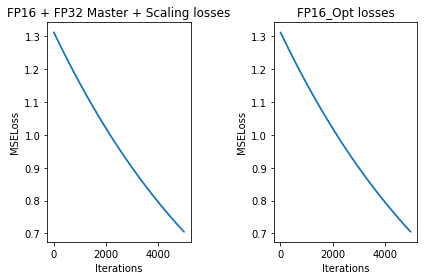

In [19]:
fig, axarr = plt.subplots(1, 2)
axarr[0].plot(np.array(fp16_scaled_losses))
axarr[0].set_xlabel('Iterations')
axarr[0].set_ylabel('MSELoss')
axarr[0].set_title('FP16 + FP32 Master + Scaling losses')
axarr[1].plot(np.array(fp16_opt_losses))
axarr[1].set_xlabel('Iterations')
axarr[1].set_ylabel('MSELoss')
axarr[1].set_title('FP16_Opt losses')
fig.tight_layout()

The interesting fact is that we just needed to change two lines of code compared to our vanilla PyTorch training procedure.

To be able to scale the loss and use FP32 Master Weights, the `FP1_Optimizer` takes the ownership of the backward pass now. Internally, references to the FP16 model parameters are stored in the instantiation step by passing the original optimizer (with references to the model parameters) to `FP16_Optimizer`. This also makes it possible to call `optimizer.zero_grad()` now instead of `model.zero_grad()` as in the manual FP16 training.

The most interesing part is the `backward()` call of the `FP16_Optimizer`, which basically performs all necessary steps for mixed precision training we were talking about before.
From the docs:
```
 1. fp32_loss = loss.float()
 2. scaled_loss = fp32_loss*loss_scale
 3. scaled_loss.backward(), which accumulates scaled gradients into the `.grad` attributes of the model's leaves.
 4. fp16 grads are then copied to the master params' `.grad` attributes, which are guaranteed to be fp32.
 5. Finally, master grads are divided by loss_scale.
```

Note that it's recommended to use the same name for your `FP16_Optimizer` as for your initial optimizer for two reasons:

 1. You don't have to change the optimizer calls in your script later on and can use the `FP16_Optimizer` as a drop-in replacement.
 2. `FP16_Optimizer` reserves the right to modify your initial optimizer. Working with both in your script might create unexpected behavior.

That's basically it! Try to play around with mixed precision training, have a look at the talks for some more information and definitely try out [apex](https://github.com/NVIDIA/apex). Also, feed back is welcome as always, so let me know what you think about this small introduction.

At this point I would like to include a citation of Michael from his GTC talk:

_Honestly, we've really never met a network that we couldn't make this work for with careful selection of the loss scale._

That sounds really promising! :)